In [1]:
import os
import glob
import time
from datetime import datetime

import torch
import numpy as np
import pandas as pd

from State import State
from GenerateDemandMonthly import GenerateDemandMonthly

from PPO import PPO

Device set to : NVIDIA GeForce RTX 3070


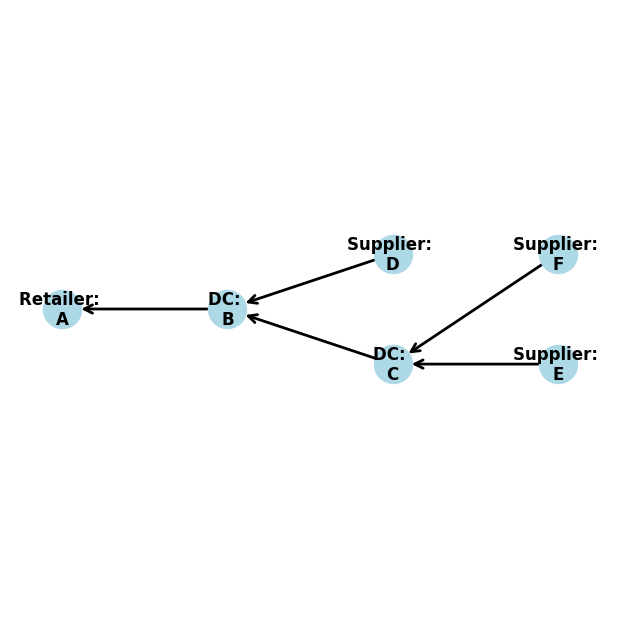

In [2]:
env = State()
env.create_state([-1, 0, 1, 1, 2, 2])
env.show_network()

In [3]:
has_continuous_action_space = False # continuous action space; else discrete
action_std = 0.6            # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.03       # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.03               # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(1e5)  # action_std decay frequency (in num timesteps
eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor
K_epochs = 20
lr_actor = 0.00005      # learning rate for actor network
lr_critic = 0.0001       # learning rate for critic network

random_seed = 1234         # set random seed if required (0 = no random seed)

state_dim = 9
action_dim = 512

In [4]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.policy_old.load_state_dict(torch.load("rlmodel3.pt"))
ppo_agent.policy.load_state_dict(torch.load("rlmodel3.pt"))

<All keys matched successfully>

In [5]:
#### Generate New Demand ####
demand_generator = GenerateDemandMonthly()

df = pd.read_csv("../src/TOTALSA.csv")
mean = df['TOTALSA'].mean()
std = df['TOTALSA'].std()
period = 108
iterations = 100

demand_matrix = np.reshape(demand_generator.simulate_normal_no_season(\
            periods = period * iterations, mean=mean, std=std),\
                (iterations, period))

In [6]:
reward_RL = []

for demand_list in demand_matrix:
    reward_total = 0
    state = env.reset()
    env.set_demand_list(demand_list)
    done = False
    reward_sub = 0
    
    while not done:
        action = ppo_agent.select_action(state)
        state, reward, done = env.step(action)
        reward_sub += reward
        print(reward)
        if done:
            break
    reward_total += reward_sub
    reward_RL.append(reward_total)
        

668.5999999999999
531.1999999999998
1110.8
802.3999999999999
760.3999999999999
937.1999999999998
1029.1999999999998
721.3999999999999
804.0
366.0
1017.8
1073.1999999999998
1089.1999999999998
490.5999999999999
775.3999999999999
790.0
979.5999999999999
976.5999999999999
1066.8
233.19999999999982
887.0
466.39999999999986
631.5999999999999
714.5999999999999
962.8
783.3999999999999
945.1999999999998
578.5999999999999
841.0
1162.8
581.3999999999999
965.5999999999999
1192.8
755.5999999999999
1150.6
756.1999999999998
695.0
558.3999999999999
909.1999999999998
1335.6
812.0
745.3999999999999
877.0
399.0
827.5999999999999
620.8
799.0
828.0
1041.1999999999998
978.5999999999999
1094.1999999999998
215.19999999999982
506.1999999999998
550.0
467.39999999999986
830.0
990.5999999999999
410.0
1181.6
1401.3999999999999
466.0
763.8
900.5999999999999
833.0
1077.1999999999998
-160.60000000000002
68.59999999999991
1274.1999999999998
-666.0
3198.3999999999996
426.79999999999995
799.5999999999999
821.19999999999

In [7]:
print(reward_RL)

[83429.79999999996, 80342.8, 83788.60000000002, 80325.40000000004, 77909.99999999999, 83519.40000000001, 85073.59999999999, 80691.59999999999, 80278.39999999998, 78309.2, 83005.99999999999, 81569.40000000001, 81069.19999999997, 79113.99999999999, 84582.6, 81643.59999999996, 81186.39999999995, 81690.19999999997, 72594.79999999997, 82945.4, 79281.99999999996, 84479.2, 82627.20000000001, 85424.0, 77451.59999999998, 82070.4, 78815.2, 83672.40000000002, 79337.00000000001, 81821.79999999994, 77645.59999999999, 77782.99999999996, 78924.99999999999, 81358.79999999999, 84402.8, 74699.39999999997, 79804.20000000003, 80486.19999999998, 83327.39999999998, 83846.40000000001, 80330.4, 82628.60000000002, 83703.6, 81340.99999999997, 78821.59999999998, 76952.19999999998, 85180.00000000007, 85868.0, 77625.39999999998, 78050.60000000002, 83398.80000000003, 79300.8, 87050.20000000004, 79831.59999999998, 82273.6, 80045.4, 78796.8, 83347.59999999999, 83743.79999999997, 75853.79999999997, 81551.4, 84113.9999

In [8]:
## Starting inventory is fixed at 65
print(np.mean(reward_RL))

80894.208


In [9]:
has_continuous_action_space = False # continuous action space; else discrete
action_std = 0.6            # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.03       # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.03               # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(1e5)  # action_std decay frequency (in num timesteps
eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor
K_epochs = 20
lr_actor = 0.00005      # learning rate for actor network
lr_critic = 0.0001       # learning rate for critic network

random_seed = 1234         # set random seed if required (0 = no random seed)

state_dim = 9
action_dim = 512

In [10]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.policy_old.load_state_dict(torch.load("rlmodel1.pt"))
ppo_agent.policy.load_state_dict(torch.load("rlmodel1.pt"))

<All keys matched successfully>

In [11]:
reward_RL = []

for demand_list in demand_matrix:
    reward_total = 0
    state = env.reset()
    env.set_demand_list(demand_list)
    done = False
    reward_sub = 0
    
    while not done:
        action = ppo_agent.select_action(state)
        state, reward, done = env.step(action)
        reward_sub += reward
        print(reward)
        if done:
            break
    reward_total += reward_sub
    reward_RL.append(reward_total)      


760.5999999999999
559.1999999999998
1010.8
867.3999999999999
925.3999999999999
892.1999999999998
1200.1999999999998
827.3999999999999
874.0
606.0
1252.8
1032.1999999999998
1290.1999999999998
370.79999999999995
1215.1999999999998
751.1999999999998
459.0
1511.1999999999998
-461.0
1068.6
1878.6
-267.8
943.8
2244.3999999999996
-559.0
2594.0
248.19999999999993
1395.6
859.0
1189.8
907.3999999999999
1114.6
292.4
918.3999999999999
-578.0
2558.3999999999996
738.3999999999999
1934.0
-423.0
2903.7999999999997
-207.4
2229.7999999999997
922.0
582.0
1011.5999999999999
-70.20000000000005
1692.0
684.5999999999999
1612.6
1003.5999999999999
69.59999999999991
1793.8
-441.0
-497.0
3183.6
573.0
-455.0
2976.6
1010.5999999999999
1330.3999999999999
580.0
-526.0
1275.3999999999999
2188.3999999999996
1031.0
805.8
743.3999999999999
1335.3999999999999
995.5999999999999
514.0
-400.0
270.4
2804.2
-197.20000000000005
955.5999999999999
2599.7999999999997
1442.0
-53.200000000000045
-713.0
328.0
3827.7999999999993
199.

In [12]:
#Starting inventory can be chosen by the RL
print(reward_RL)

[102365.80000000003, 99592.60000000002, 102730.40000000001, 101634.40000000002, 99069.0, 87294.40000000001, 100767.40000000001, 100279.79999999997, 99653.40000000001, 100522.20000000001, 103214.80000000005, 105815.59999999999, 103131.59999999996, 105379.59999999999, 107864.59999999992, 101713.60000000002, 105768.2, 98068.80000000005, 99921.6, 102020.40000000001, 99919.99999999997, 82912.00000000001, 94983.40000000002, 93776.40000000002, 99635.99999999996, 103928.20000000004, 102260.19999999997, 105066.60000000002, 87729.40000000002, 101861.79999999996, 105133.59999999998, 100994.0, 103679.0, 104107.8, 103624.80000000002, 98203.59999999995, 97133.00000000001, 100837.99999999997, 99429.60000000002, 101422.19999999998, 100798.0, 105017.6, 99810.60000000002, 93654.60000000002, 102423.60000000006, 94552.40000000004, 104881.40000000004, 104579.00000000003, 97854.19999999998, 100894.6, 103702.79999999999, 101769.80000000003, 99461.00000000003, 101204.60000000003, 90532.59999999998, 105336.399

In [13]:
print(np.mean(reward_RL))

100781.05799999999
